<a href="https://colab.research.google.com/github/Navikasrikanth/Physic-Informed-Neural-Network/blob/main/Final_ML_Model_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Define Poisson’s Equation and Boundary Conditions
##We are solving the 2D Poisson equation:

Δu(x, y) = f(x, y), for (x, y) ∈ [0,1] × [0,1]

Boundary conditions: u(x, y) = 0, for (x, y) on the boundary (Dirichlet BC).

Here, Δ is the Laplace operator.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
import torch
torch.cuda.is_available()

POLY_TYPE = "sin(pi*x)*sin(pi*y)"
ACTIVATION = "Tanh"
LEARNING_RATE = 5e-4
NOISE_LEVEL = 0.0
N_F = 30000
N_B = 800
EPOCHS_FORWARD = 3000
EPOCHS_INVERSE = 5000
PRINT_EVERY = 100

print("Architecture: Fully-connected MLP (2 -> 200 -> 200 -> 200 -> 1)")
print("Solution type:", POLY_TYPE)
print("Activation:", ACTIVATION)
print("Learning rate:", LEARNING_RATE)
print("Noise level:", NOISE_LEVEL)
print("Collocation points (interior):", N_F)
print("Boundary points:", N_B)
print("Epochs (forward):", EPOCHS_FORWARD, "Epochs (inverse):", EPOCHS_INVERSE)
print("Device:", device)



Architecture: Fully-connected MLP (2 -> 200 -> 200 -> 200 -> 1)
Solution type: sin(pi*x)*sin(pi*y)
Activation: Tanh
Learning rate: 0.0005
Noise level: 0.0
Collocation points (interior): 30000
Boundary points: 800
Epochs (forward): 3000 Epochs (inverse): 5000
Device: cuda


###Generate Forward Problem Data

In this step, we set up the data for the forward problem:

- We define the exact solution `u(x, y)` as `A * sin(pi*x) * sin(pi*y)`.
- The source function `f(x, y)` is defined as `-2 * pi^2 * A * sin(pi*x) * sin(pi*y)`.
- The boundary function `g(x, y)` gives the values of `u` on the edges of the domain.

Next, we generate:

- **Interior collocation points** randomly inside the square domain.
- **Boundary points** along the edges of the domain.
- **Boundary values** using the boundary function.




In [11]:
A_true = 1.0

def u_exact_func(x, y, A=A_true):
  return A * torch.sin(np.pi * x) * torch.sin(np.pi * y)

def f_forward_func(x, y, A=A_true):
  return -2 * (np.pi**2) * A * torch.sin(np.pi * x) * torch.sin(np.pi * y)

def g_boundary(x, y, A=A_true):
  return u_exact_func(x, y, A=A)

x_f = torch.rand(N_F, 1, device=device) #compute collocation points
y_f = torch.rand(N_F, 1, device=device)

n_edge = N_B // 4
x_b = torch.cat([                #combine all boundary points
torch.rand(n_edge,1),
torch.zeros(n_edge,1),
torch.ones(n_edge,1),
torch.rand(n_edge,1)
], dim=0).to(device)
y_b = torch.cat([
torch.zeros(n_edge,1),
torch.rand(n_edge,1),
torch.rand(n_edge,1),
torch.ones(n_edge,1)
], dim=0).to(device)

u_b = g_boundary(x_b, y_b).to(device)        #assign boundary points to the boumdary function and predict exact boundary values
if NOISE_LEVEL > 0:
  u_b = u_b + NOISE_LEVEL * torch.randn_like(u_b)


# Define Neural Network

In this step, we define a simple fully connected neural network with:

- Input: two values (x and y)
- Three hidden layers with 200 neurons and Tanh activation
- Output: single value u(x, y)
- Xavier initialization for all linear layer weights and zero initialization for biases


## **Xavier (Glorot) Initialization**
Xavier initialization (also called Glorot initialization) is a way to set the initial weights of a neural network so that signals flow properly through the layers at the start of training.


When training neural networks, how we initialize weights matters.  
- If weights are **too small** → activations and gradients vanish.  
- If weights are **too large** → activations and gradients explode.  


**Xavier initialization** (Glorot & Bengio, 2010) balances this by keeping the variance of activations roughly the same across all layers.


In [12]:
class PINN(nn.Module):                                       #initialise a fully connected nn with x,y inputs
  def __init__(self, hidden_dim=200, activation=nn.Tanh):
    super().__init__()
    self.fc1 = nn.Linear(2, hidden_dim)
    self.act1 = activation()
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.act2 = activation()
    self.fc3 = nn.Linear(hidden_dim, hidden_dim)
    self.act3 = activation()
    self.fc4 = nn.Linear(hidden_dim, 1)

    # Xavier init
    for m in [self.fc1, self.fc2, self.fc3, self.fc4]:
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)

  def forward(self, x, y):                  #moving forward by using activation function through each layer till output
    inp = torch.cat([x, y], dim=1)
    z = self.act1(self.fc1(inp))
    z = self.act2(self.fc2(z))
    z = self.act3(self.fc3(z))
    out = self.fc4(z)
    return out



# Define Loss Function

In this step, we define how the model will be trained:

- Compute the Laplacian (second derivatives) of the predicted u(x, y) using automatic differentiation.
- Compute the PDE residual loss at interior collocation points.
- Compute the boundary loss at boundary points.
- Total loss = PDE residual loss + boundary loss
- Return both the total loss and individual losses for monitoring.


In [13]:
mse_loss = nn.MSELoss()

def laplacian_u(model, x, y):                             #computes uxx+uyy using automatic differentiation
  x_req = x.clone().detach().requires_grad_(True)
  y_req = y.clone().detach().requires_grad_(True)
  u = model(x_req, y_req)
  grad_u = torch.autograd.grad(u, [x_req, y_req], grad_outputs=torch.ones_like(u), create_graph=True)
  u_x = grad_u[0]
  u_y = grad_u[1]
  u_xx = torch.autograd.grad(u_x, x_req, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
  u_yy = torch.autograd.grad(u_y, y_req, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
  return u_xx + u_yy

def pinn_loss_forward(model, x_f, y_f, x_b, y_b, u_b):
  f_pred = laplacian_u(model, x_f, y_f)           #computing left hand side u(x,y) at collocation points
  f_true = f_forward_func(x_f, y_f).to(device)    #computing right hand side true function f(x,y)
  #loss_f = mse_loss(f_pred, f_true)               #residual loss
  loss_f = torch.mean((f_pred - f_true)**2) / (torch.mean(f_true**2) + 1e-8)
  u_b_pred = model(x_b, y_b)
  loss_b = mse_loss(u_b_pred, u_b)                #boundary loss
  return loss_f + loss_b, loss_f.item(), loss_b.item()

# Train the Forward PINN

In this step, we train the neural network to solve the Poisson equation:

- Use the Adam optimizer with a specified learning rate.
- For each epoch:
  - Compute the total loss using the `pinn_loss_forward` function.
  - Perform backpropagation and update the model parameters.
  - Periodically print the total loss, PDE residual loss, and boundary loss to monitor training progress.


In [14]:
# ---------- Forward training ----------
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
mse_loss = nn.MSELoss()

print("Starting forward training...")
for epoch in range(1, 3001):
    model.train()
    optimizer.zero_grad()

    total_loss, loss_f, loss_b = pinn_loss_forward(model, x_f, y_f, x_b, y_b, u_b)
    total_loss.backward()

    f_pred = laplacian_u(model, x_f, y_f)
    f_true = f_forward_func(x_f, y_f).to(device)

    #Normalize PDE residual
    loss_f = torch.mean((f_pred - f_true)**2) / (torch.mean(f_true**2) + 1e-8)
    u_b_pred = model(x_b, y_b)
    loss_b = mse_loss(u_b_pred, u_b)

    total_loss = loss_f + loss_b
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    optimizer.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"[Forward] Epoch {epoch}/3000  Total: {total_loss.item():.6e}  f_loss: {loss_f.item():.6e}  b_loss: {loss_b.item():.6e}")


Starting forward training...
[Forward] Epoch 1/3000  Total: 1.122806e+00  f_loss: 1.010256e+00  b_loss: 1.125498e-01
[Forward] Epoch 100/3000  Total: 1.160370e-01  f_loss: 8.201018e-02  b_loss: 3.402681e-02
[Forward] Epoch 200/3000  Total: 4.308339e-02  f_loss: 2.990763e-02  b_loss: 1.317576e-02
[Forward] Epoch 300/3000  Total: 1.109114e-02  f_loss: 5.871294e-03  b_loss: 5.219852e-03
[Forward] Epoch 400/3000  Total: 2.517569e-03  f_loss: 1.379803e-03  b_loss: 1.137766e-03
[Forward] Epoch 500/3000  Total: 7.329967e-04  f_loss: 4.735841e-04  b_loss: 2.594126e-04
[Forward] Epoch 600/3000  Total: 4.828398e-04  f_loss: 2.738959e-04  b_loss: 2.089438e-04
[Forward] Epoch 700/3000  Total: 2.282278e-04  f_loss: 1.820633e-04  b_loss: 4.616456e-05
[Forward] Epoch 800/3000  Total: 1.781623e-04  f_loss: 1.371005e-04  b_loss: 4.106177e-05
[Forward] Epoch 900/3000  Total: 1.294342e-04  f_loss: 1.080243e-04  b_loss: 2.140987e-05
[Forward] Epoch 1000/3000  Total: 1.079431e-04  f_loss: 8.988672e-05  b_l

#Inverse Problem Training

Start from the forward-trained model to estimate the unknown 𝛼.

Use beta as a trainable parameter with 𝛼=exp(𝛽)

Train for 12,000 epochs with weighted PDE and boundary losses.

Track the best
𝛼 and total loss.

Fine-tune for 500 additional epochs at a lower learning rate to refine
𝛼

Epoch display shows correct progress for both main training and fine-tuning.

In [15]:
# ---------- Inverse training ----------
beta = torch.tensor(np.log(0.8), requires_grad=True, device=device)  # reparam alpha=exp(beta)
model_inv = PINN().to(device)
model_inv.load_state_dict(model.state_dict())  # starts from forward-trained model

optimizer_inv = optim.Adam([
    {'params': model_inv.parameters(), 'lr': 1e-3},
    {'params': [beta], 'lr': 3e-3}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(                      #lr scheduler(lowers lr to take small steps) to decrease lr when loss stops decreasing
    optimizer_inv, mode='min', factor=0.5, patience=300, min_lr=1e-6
)

def pinn_loss_inverse(model, beta_param, x_f, y_f, x_b, y_b, u_b):
    alpha_param = torch.exp(beta_param)
    f_pred = laplacian_u(model, x_f, y_f)
    f_true = (-2 * (np.pi**2) * alpha_param * torch.sin(np.pi * x_f) * torch.sin(np.pi * y_f)).to(device)
    loss_f = torch.mean((f_pred - f_true)**2) / (torch.mean(f_true**2) + 1e-8)
    u_b_pred = model(x_b, y_b)
    loss_b = mse_loss(u_b_pred, u_b)
    total = 2.0 * loss_f + 1.0 * loss_b   # Increase PDE focus

    return total, loss_f.item(), loss_b.item(), alpha_param.item()

print("Starting inverse training...")
best_loss = 1e9               #Initialize best_loss large and best_alpha to store the best (smallest) loss and corresponding alpha seen during training.
best_alpha = None

total_epochs = 12000  # main inverse training
for epoch in range(1, total_epochs + 1):
    model_inv.train()
    optimizer_inv.zero_grad()        #Setting all .grad values of model parameters to zero before computing new gradients

    total_loss, loss_f_inv, loss_b_inv, alpha_val = pinn_loss_inverse(model_inv, beta, x_f, y_f, x_b, y_b, u_b)
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(list(model_inv.parameters()) + [beta], max_norm=2.0)  #prevents exploding gradients by scaling them down if their combined norm > 2.0.
    optimizer_inv.step()
    scheduler.step(total_loss.detach())   #Tell the LR scheduler the current metric (total_loss) so it can monitor progress.

    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        best_alpha = alpha_val

    if epoch % 100 == 0 or epoch == 1:
        print(f"[Inverse] Epoch {epoch}/{total_epochs}  Total: {total_loss.item():.6e}  f_loss: {loss_f_inv:.6e}  b_loss: {loss_b_inv:.6e}  alpha={alpha_val:.6f}")

learned_alpha = torch.exp(beta).item()
print("\nFinal learned alpha from inverse training:", learned_alpha)
print("Best alpha encountered during training:", best_alpha)

# Fine-tune last 500 epochs at lower LR
for g in optimizer_inv.param_groups:
    g['lr'] = 5e-4  # smaller LR

fine_tune_start = 12001
fine_tune_end = 12500

for epoch in range(fine_tune_start, fine_tune_end + 1):
    total_loss, loss_f_inv, loss_b_inv, alpha_val = pinn_loss_inverse(model_inv, beta, x_f, y_f, x_b, y_b, u_b)
    optimizer_inv.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(list(model_inv.parameters()) + [beta], max_norm=2.0)
    optimizer_inv.step()

    # print relative to fine-tune epochs
    if (epoch - fine_tune_start + 1) % 50 == 0 or epoch == fine_tune_start:
        ft_epoch = epoch - fine_tune_start + 1
        print(f"[Inverse Fine-tune] Epoch {ft_epoch}/500  Total: {total_loss.item():.6e}  f_loss: {loss_f_inv:.6e}  b_loss: {loss_b_inv:.6e}  alpha={alpha_val:.6f}")


Starting inverse training...
[Inverse] Epoch 1/12000  Total: 1.225558e-01  f_loss: 6.123400e-02  b_loss: 8.777406e-05  alpha=0.800000
[Inverse] Epoch 100/12000  Total: 5.256696e-05  f_loss: 2.424395e-05  b_loss: 4.079053e-06  alpha=0.813677
[Inverse] Epoch 200/12000  Total: 3.529952e-05  f_loss: 1.666178e-05  b_loss: 1.975951e-06  alpha=0.814012
[Inverse] Epoch 300/12000  Total: 2.978658e-05  f_loss: 1.419447e-05  b_loss: 1.397650e-06  alpha=0.814235
[Inverse] Epoch 400/12000  Total: 3.538305e-04  f_loss: 1.050884e-04  b_loss: 1.436536e-04  alpha=0.815141
[Inverse] Epoch 500/12000  Total: 2.748154e-05  f_loss: 1.239658e-05  b_loss: 2.688388e-06  alpha=0.816860
[Inverse] Epoch 600/12000  Total: 2.197280e-05  f_loss: 1.045377e-05  b_loss: 1.065261e-06  alpha=0.816634
[Inverse] Epoch 700/12000  Total: 8.151274e-04  f_loss: 1.749849e-04  b_loss: 4.651575e-04  alpha=0.818620
[Inverse] Epoch 800/12000  Total: 7.668891e-04  f_loss: 2.062933e-04  b_loss: 3.543026e-04  alpha=0.818654
[Inverse] 

###Predict Solutions for Forward and Inverse Problems

In this step, we:

- Generate a grid of points in the domain for testing.
- Use the trained **forward model** to predict u(x, y) across the domain.
- Use the trained **inverse model** to predict u(x, y) and recover the learned parameter alpha.
- Store the exact solution for comparison.

In [16]:
n_test = 50
x_vals = torch.linspace(0,1,n_test, device=device).reshape(-1,1)
y_vals = torch.linspace(0,1,n_test, device=device).reshape(-1,1)
Xg, Yg = torch.meshgrid(x_vals.squeeze(), y_vals.squeeze(), indexing="ij")
xg_flat = Xg.reshape(-1,1)
yg_flat = Yg.reshape(-1,1)

model.eval()
with torch.no_grad():
  u_pred_forward = model(xg_flat, yg_flat).cpu()
  u_exact_all = u_exact_func(xg_flat.cpu(), yg_flat.cpu(), A=A_true)

model_inv.eval()
with torch.no_grad():
  u_pred_inverse = model_inv(xg_flat, yg_flat).cpu()
  u_exact_inv = u_exact_func(xg_flat.cpu(), yg_flat.cpu(), A=A_true)
  learned_alpha = torch.exp(beta).item()



# **RESULTS VISUALISATION**

## Compute Metrics and Show Sample Predictions

In this step, we evaluate the performance of the forward and inverse PINN models:

- Compute **Mean Squared Error (MSE)** between predicted and exact solutions.
- Compute **Relative L2 Error**.
- Compute approximate **accuracy** as a percentage.
- Print the **learned parameter alpha** from the inverse problem.
- Display a few **sample predictions** from both forward and inverse models alongside the exact values.


In [17]:
def compute_metrics(u_pred, u_exact):
  diff = u_pred - u_exact
  mse = torch.mean(diff**2).item()
  rel_l2 = (torch.norm(diff) / torch.norm(u_exact)).item()
  acc_percent = max(0.0, (1 - rel_l2) * 100)
  return mse, rel_l2, acc_percent

mse_fwd, rel_fwd, acc_fwd = compute_metrics(u_pred_forward, u_exact_all)
mse_inv, rel_inv, acc_inv = compute_metrics(u_pred_inverse, u_exact_all)

print("\n--- Forward-trained model metrics ---")
print("MSE:", mse_fwd)
print("Relative L2 Error:", rel_fwd)
print(f"Accuracy (approx): {acc_fwd:.2f}%")

print("\n--- Inverse-trained model metrics ---")
print("MSE:", mse_inv)
print("Relative L2 Error:", rel_inv)
print(f"Accuracy (approx): {acc_inv:.2f}%")
print("Learned alpha (inverse):", learned_alpha)
print("True amplitude A_true:", A_true)

print("\nSample predictions (forward model):")
for i in range(5):
  print(f"x={xg_flat[i].item():.3f}, y={yg_flat[i].item():.3f}, u_pred={u_pred_forward[i].item():.6f}, u_exact={u_exact_all[i].item():.6f}")
print("\nSample predictions (inverse model):")
for i in range(5):
  print(f"x={xg_flat[i].item():.3f}, y={yg_flat[i].item():.3f}, u_pred={u_pred_inverse[i].item():.6f}, u_exact={u_exact_inv[i].item():.6f}")


--- Forward-trained model metrics ---
MSE: 9.740932000568137e-05
Relative L2 Error: 0.020142076537013054
Accuracy (approx): 97.99%

--- Inverse-trained model metrics ---
MSE: 0.007322503719478846
Relative L2 Error: 0.17463602125644684
Accuracy (approx): 82.54%
Learned alpha (inverse): 0.8245880145113128
True amplitude A_true: 1.0

Sample predictions (forward model):
x=0.000, y=0.000, u_pred=-0.002325, u_exact=0.000000
x=0.000, y=0.020, u_pred=-0.002361, u_exact=0.000000
x=0.000, y=0.041, u_pred=-0.002465, u_exact=0.000000
x=0.000, y=0.061, u_pred=-0.002605, u_exact=0.000000
x=0.000, y=0.082, u_pred=-0.002764, u_exact=0.000000

Sample predictions (inverse model):
x=0.000, y=0.000, u_pred=0.001599, u_exact=0.000000
x=0.000, y=0.020, u_pred=0.001364, u_exact=0.000000
x=0.000, y=0.041, u_pred=0.001103, u_exact=0.000000
x=0.000, y=0.061, u_pred=0.000829, u_exact=0.000000
x=0.000, y=0.082, u_pred=0.000555, u_exact=0.000000


##Visualize Predictions and Errors

In this step, we plot heatmaps to visually compare the forward and inverse PINN predictions against the exact solution:

- First row: forward problem
  - Predicted solution
  - Exact solution
  - Absolute error
- Second row: inverse problem
  - Predicted solution
  - Exact solution
  - Absolute error

This helps to see where the model is accurate and where errors are larger.


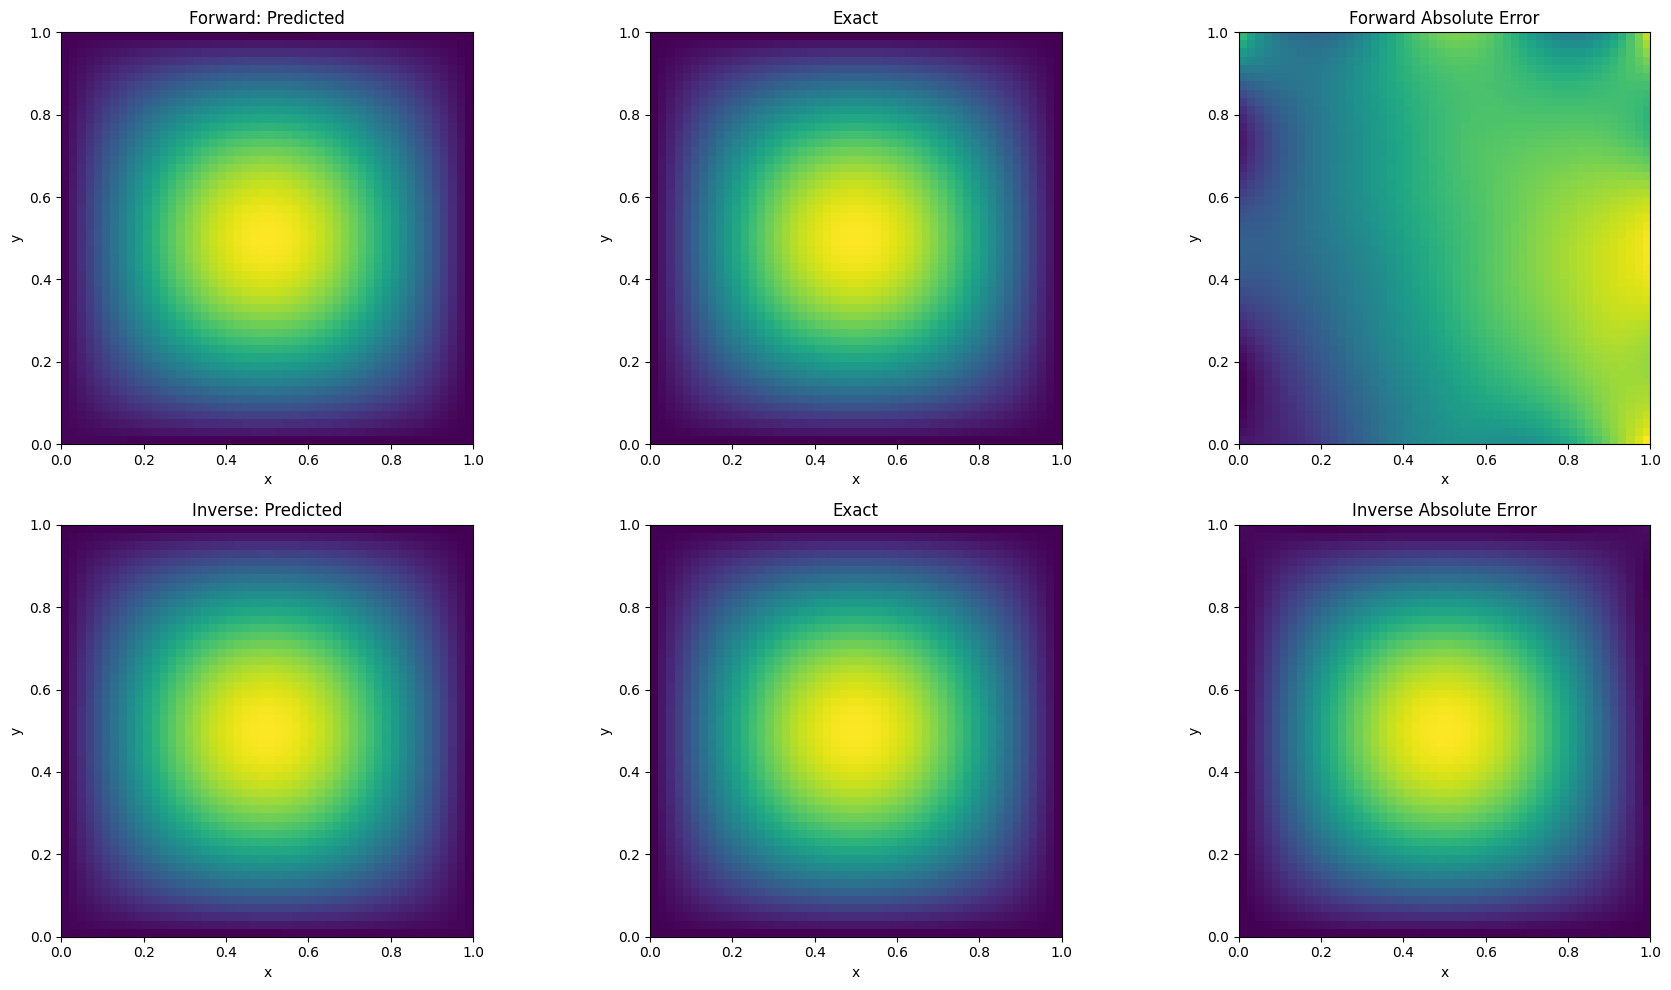

In [18]:
u_pred_forward_np = u_pred_forward.numpy().reshape(n_test, n_test)
u_exact_np = u_exact_all.numpy().reshape(n_test, n_test)
u_pred_inverse_np = u_pred_inverse.numpy().reshape(n_test, n_test)

fig, axs = plt.subplots(2,3, figsize=(18,10))

axs[0,0].imshow(u_pred_forward_np, origin='lower', extent=[0,1,0,1])
axs[0,0].set_title("Forward: Predicted")
axs[0,1].imshow(u_exact_np, origin='lower', extent=[0,1,0,1])
axs[0,1].set_title("Exact")
axs[0,2].imshow(np.abs(u_pred_forward_np - u_exact_np), origin='lower', extent=[0,1,0,1])
axs[0,2].set_title("Forward Absolute Error")

axs[1,0].imshow(u_pred_inverse_np, origin='lower', extent=[0,1,0,1])
axs[1,0].set_title("Inverse: Predicted")
axs[1,1].imshow(u_exact_np, origin='lower', extent=[0,1,0,1])
axs[1,1].set_title("Exact")
axs[1,2].imshow(np.abs(u_pred_inverse_np - u_exact_np), origin='lower', extent=[0,1,0,1])
axs[1,2].set_title("Inverse Absolute Error")

for ax in axs.flat:
  ax.set_xlabel("x")
  ax.set_ylabel("y")

plt.tight_layout()
plt.show()